# In this notebook I will write a tensorflow convolutional neural network with the ability to perform advanced classification of chest X-rays, distinguishing between Covid-19, Viral Pneumonia, and healthy cases

I got the dataset from here: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

I will follow these steps:

1. Data exploration
2. Data visualization
3. TF dataset creation
4. Partition data into train/val/test
5. Optimize performance
6. Create CNN
7. Fit the CNN
8. Evaluate the CNN
9. Predictions

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image

## Exploration

In [3]:
data_path = 'dataset/'

In [4]:
import os
img_dirs = []
for data in os.scandir(data_path):
    if data.is_dir():
        img_dirs.append(data.path + '/images')

In [5]:
img_dirs

['dataset/Covid/images',
 'dataset/Normal/images',
 'dataset/Viral Pneumonia/images']

In [6]:
for directory in img_dirs:
    number_of_images = len(os.listdir(directory))
    print(f"Amount of {directory.split('/')[1]} images: {number_of_images}")

Amount of Covid images: 3616
Amount of Normal images: 10192
Amount of Viral Pneumonia images: 1345


Plenty of images to train my CNN on

I know that all images are 299x299

### Visualization

In [7]:
images = []
for directory in img_dirs:
    images.append(directory + "/" + os.listdir(directory)[0])
images

['dataset/Covid/images/COVID-1.png',
 'dataset/Normal/images/Normal-1.png',
 'dataset/Viral Pneumonia/images/Viral Pneumonia-1.png']

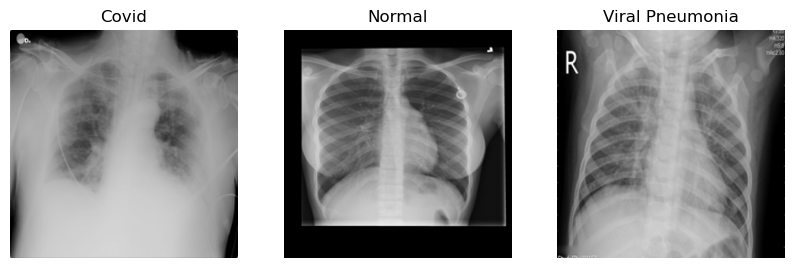

In [8]:
plt.figure(figsize = (10, 10))
for i in range(len(images)):
    ax = plt.subplot(1, 3, 1 + i)
    img = cv2.imread(images[i])
    plt.imshow(img)
    plt.title(images[i].split('/')[1])
    plt.axis('off')

In [9]:
for image in images:
    img = cv2.imread(image)
    print(img.shape)

(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


## Dataset creation

In [10]:
#variables to use later
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
IMAGE_SIZE = 256
CHANNELS = 3

In [11]:
# Create TensorFlow dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #dataset
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 15153 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['Covid', 'Normal', 'Viral Pneumonia']


In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 1 1 0 2 1 1 1 2 1 2 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1]


## Partition data into train/val/test

In [14]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    """
    A function that takes a dataset and splits it into train, test, and validation sets and shuffles it.
    """
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_ds = ds.take(int(ds_size*train_split)) # first 80% of data
    print(len(train_ds))
    remaining = ds.skip(len(train_ds)) # skips the first 80% of data and assigns the last 20% to remaining
    val_ds = remaining.take(int(ds_size*val_split)) # gets the len of images of 10% of the total data set, then takes is out of remaining (should be 50% of remaining)
    print(len(val_ds))
    test_ds = remaining.skip(len(val_ds)) # Skips over the amount taken by val and assigns to test. SHould be 50% of remaining
    print(len(test_ds))
    return train_ds, val_ds, test_ds

In [15]:
train, val, test = get_dataset_partitions(dataset)

379
47
48


## Optimize performance

In [16]:
train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(299, 299), 
    layers.experimental.preprocessing.Rescaling(1.0/255) #scale so every value is between 1-255
])

## Create CNN

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape), #amount of filters, kernel size (using 3,3 filter) 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), #trial and error with amount of layers
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 299, 299, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 297, 297, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 148, 148, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 146, 146, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 73, 73, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

In [23]:
model.compile(
    optimizer = 'adam', # looked up which optimizer I should use
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'] # Going to use accuracy as my metric
)

In [24]:
history = model.fit(
    train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val
)

Epoch 1/50
379/379 [==============================] - 31s 64ms/step - loss: 0.5986 - accuracy: 0.7413 - val_loss: 0.4193 - val_accuracy: 0.8132
Epoch 2/50
379/379 [==============================] - 28s 61ms/step - loss: 0.4059 - accuracy: 0.8272 - val_loss: 0.4006 - val_accuracy: 0.8351
Epoch 3/50
379/379 [==============================] - 29s 63ms/step - loss: 0.3453 - accuracy: 0.8507 - val_loss: 0.3104 - val_accuracy: 0.8783
Epoch 4/50
379/379 [==============================] - 29s 61ms/step - loss: 0.2986 - accuracy: 0.8760 - val_loss: 0.3130 - val_accuracy: 0.8710
Epoch 5/50
379/379 [==============================] - 28s 61ms/step - loss: 0.2700 - accuracy: 0.8894 - val_loss: 0.2284 - val_accuracy: 0.9109
Epoch 6/50
379/379 [==============================] - 29s 62ms/step - loss: 0.2282 - accuracy: 0.9084 - val_loss: 0.2172 - val_accuracy: 0.9169
Epoch 7/50
379/379 [==============================] - 27s 57ms/step - loss: 0.2155 - accuracy: 0.9134 - val_loss: 0.1579 - val_accuracy:

In [25]:
scores = model.evaluate(test)

48/48 [==============================] - 7s 19ms/step - loss: 0.0212 - accuracy: 0.9909


## .99 accuracy. I'm happy with that

## Evaluate the CNN

In [26]:
history

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.7412697076797485,
 0.8272104263305664,
 0.8506761193275452,
 0.8760010004043579,
 0.8893750309944153,
 0.9083938002586365,
 0.913398802280426,
 0.9214067459106445,
 0.9328820109367371,
 0.9411376118659973,
 0.9490630030632019,
 0.9494757652282715,
 0.956658124923706,
 0.9628133177757263,
 0.9670602083206177,
 0.9667299389839172,
 0.9726740121841431,
 0.976223886013031,
 0.9745727777481079,
 0.9788918495178223,
 0.982993483543396,
 0.9816128015518188,
 0.9811772704124451,
 0.9826632738113403,
 0.9867085218429565,
 0.9838190078735352,
 0.9844794869422913,
 0.9824981689453125,
 0.9879468083381653,
 0.9877817034721375,
 0.9920746088027954,
 0.987384557723999,
 0.9862131476402283,
 0.9943861961364746,
 0.989020049571991,
 0.9901758432388306,
 0.9903409481048584,
 0.9900932908058167,
 0.9903529286384583,
 0.991496741771698,
 0.9912490844726562,
 0.9891851544380188,
 0.9919920563697815,
 0.9931563138961792,
 0.9932388067245483,
 0.9937257766723633,
 0.9925791621208191,
 0.9934780597686768,

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

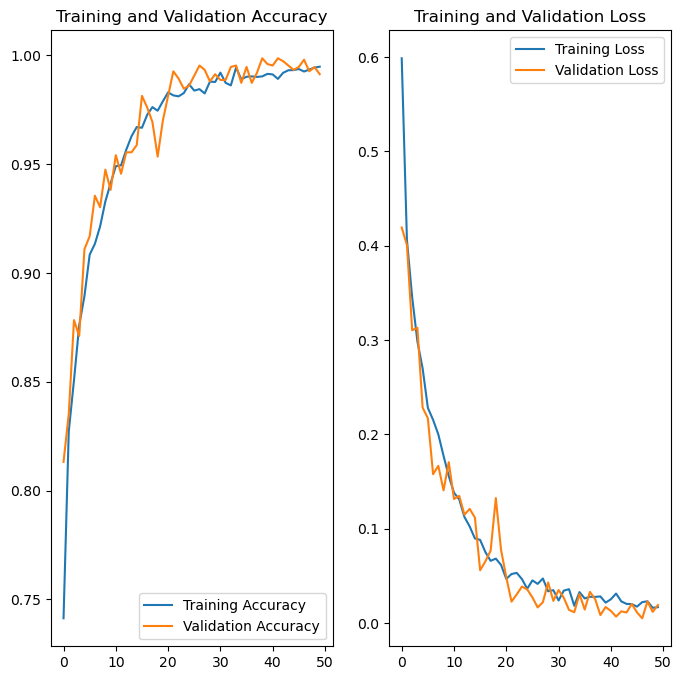

In [50]:
# plot lines 
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy") 
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy") 
plt.legend() 
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss") 
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss") 
plt.legend() 
plt.title("Training and Validation Loss")
plt.show()

## Predictions

Actual Label: Covid
1/1 [==============================] - 0s 37ms/step
Predicted label: Covid


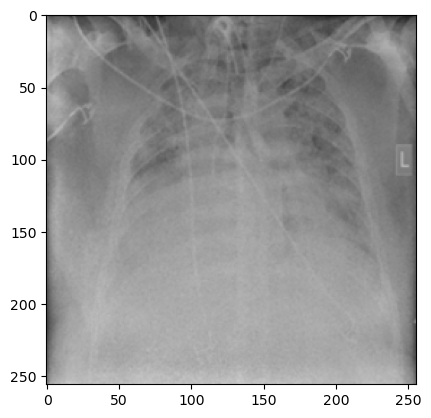

In [67]:
import numpy as np
for image_batch, label_batch in test.take(1):
    actual_label = class_names[label_batch.numpy()[0]]
    print(f"Actual Label: {actual_label}")
    predict_batch = model.predict(image_batch) #predict takes a whole batch
    image_prediction = predict_batch[0] #take the first one
    print(f"Predicted label: {class_names[int(np.argmax(image_prediction))]}") #index of largest number is the class name
    plt.imshow(image_batch[0].numpy().astype('uint8'))

### Predict a few samples

1/1 [==============================] - 0s 36ms/step


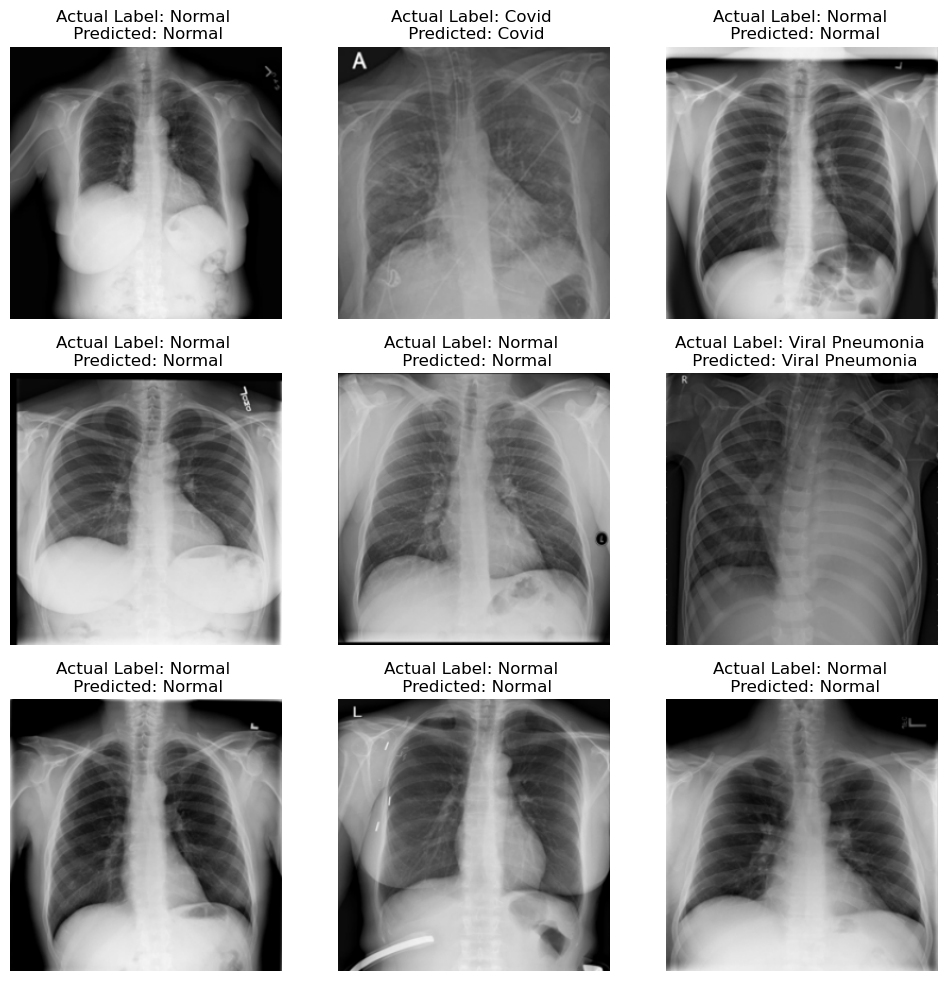

In [74]:
for image_batch, label_batch in test.take(1):
    plt.figure(figsize = (12, 12))
    predict_batch = model.predict(image_batch)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        actual_label = class_names[label_batch.numpy()[i]]
        image_prediction = predict_batch[i]
        plt.title(f"Actual Label: {actual_label} \n Predicted: {class_names[int(np.argmax(image_prediction))]}")
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [75]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
